In [1]:
from input_mu2_svmm import SVMM, plot_SVMM
from pandas import read_csv
from scipy.stats import geom, norm, multinomial
from scipy import special
import matplotlib.pyplot as plt 
import numpy as np
from joblib import Parallel, delayed
import random

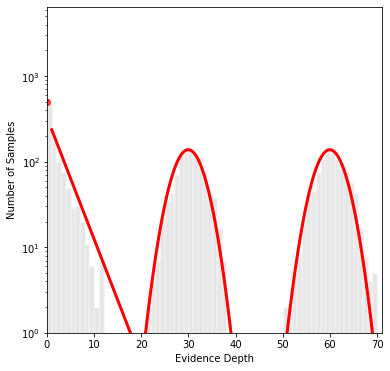

In [2]:
file_name = 'test_3mode.csv'
file = read_csv('../data/'+file_name, header = None)
X = file.values[0]
N = len(X)
pi, alpha, lambda_, mu, sigma = SVMM(X, 30, True, False)

In [3]:
def theta_to_data(N, pi, alpha, lambda_, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)
    draws_alpha = multinomial.rvs(n = draws[0], p = [alpha, 1 - alpha])

    X = [0 for _ in range(draws_alpha[0])]
    X_l = geom.rvs(1/lambda_, size = draws_alpha[1])
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    X = np.concatenate((X,X_l))
    X = np.concatenate((X,X_g))
    X = np.concatenate((X,X_g2))
    X = np.round(X).astype(int)

    return X

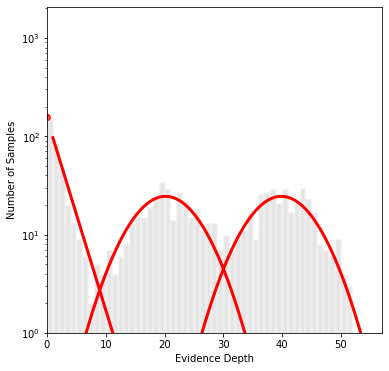

(array([0.33727733, 0.32777925, 0.33494343]),
 0.4624689939535294,
 2.22965383908716,
 [20.173209477919023, 39.89154549637818],
 [5.343024482546313, 5.026481689147534])

In [4]:
N = 1000
pi = [1/3, 1/3, 1/3]
alpha = 0.5
lambda_ = 2
mu_2 = 20
sigma = [5, 5]

X_gen = theta_to_data(N, pi, alpha, lambda_, mu_2, sigma)
SVMM(X_gen, mu_2, True, False)

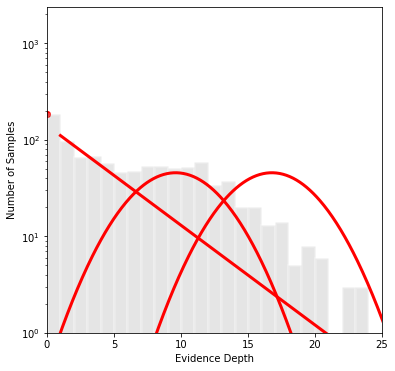

(array([0.58947503, 0.3551723 , 0.05535266]),
 0.3097785801293705,
 4.207479841780906,
 [9.600619276301925, 16.78755338994378],
 [3.114780592682227, 3.1499657842999627])

In [5]:
mu_2 = 5
X_gen = theta_to_data(N, pi, alpha, lambda_, mu_2, sigma)
SVMM(X_gen, mu_2, True, False)

In [6]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu, sigma)
    mu_2_hat = SVMM(X_gen, mu, False, False)[3][0]
    return mu_2_hat

def plot_mu(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for mu in mus:
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

KeyboardInterrupt: 

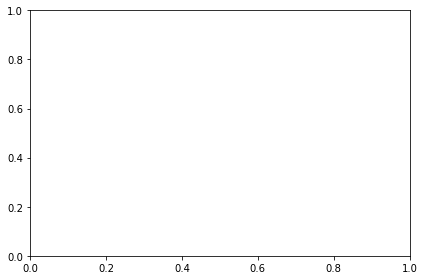

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_mu(N, pi, alpha, lambda_, sigma, 1,25,1)
plt.scatter(mus, ests, marker = 'v', color = '#6600CC', label = r'$\theta = {0.5, 2, \mu_2, 5, 5}$, medium variance', zorder = 4)

mus, ests = plot_mu(N, pi, alpha, 10, sigma, 1.1, 25.1,1.1)
plt.scatter(mus, ests, marker = '.', s = 100,color = '#9933FF',label = r'$\theta = {0.5, 10, \mu_2, 5, 5}$, high $\lambda$', zorder = 3)

mus, ests = plot_mu(N, pi, alpha, lambda_, [7,7], 1.2,25.2,1.2)
plt.scatter(mus, ests, marker = '^', color = '#CC99FF', label = r'$\theta = {0.5, 2, \mu_2, 7, 7}$, high variance', zorder = 2)
plt.plot(mus, mus,'--',color = 'black', label = 'true mean', zorder = 1)

ax.set_xlabel(r'true mean value, $\mu_2$')
ax.set_ylabel(r'estimated mean value, $\hat{\mu_2}$')
plt.legend(loc = 'lower right', fontsize = 'small', frameon = False, title = r'$n = 1000, \pi = [\frac{1}{3},\frac{1}{3},\frac{1}{3}]$')
plt.show()